# Predicting the sales in a new Big Mart outlet
In this notebook, I present an alternative approach to making use of the 2013 sales data of Big Mart. Instead of predicting the sales of each item in every store (as it is done in predict_full.ipynb), I focus on the sales of the individual products in a single store (e.g., for a new store that is about to open). Here, I use the sales data for the other stores as features in the prediction. Again, this is a regression problem, which I will address using Python, particularly the scikit-learn module.

More information about the data set are available [here](https://www.kaggle.com/arashnic/big-mart-sale-forecast).

In [1]:
# Import the relevant modules
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso

## Auxiliary functions
Below are some functions that are used later in the notebook.

In [2]:
def load_data(filename,store):
    
    data = pd.read_csv(filename)

    # Pivot table
    data_p = data.pivot(index='Item_Identifier',columns='Outlet_Identifier',values='Item_Outlet_Sales')

    # Select only the items that are sold in the particular store
    data_p = data_p[data_p[store].notna()]

    
    X = data_p.drop(store,axis=1)
    y = data_p[store]
    
    return X, y,data



def feature_engineering(X_train,X_test,data,store,Include_Item_MRP=True):
    
    def compute_total_sales(X):
        outlet_sales = data.groupby('Outlet_Identifier')[['Outlet_Type']].apply(pd.DataFrame.mode).droplevel(1)
        outlet_sales['Total_Outlet_Sales'] = X.sum()
        outlet_sales.reset_index(inplace=True)

        dummy = outlet_sales.groupby('Outlet_Type')[['Total_Outlet_Sales']].mean().reset_index()
        dummy.rename(columns={'Total_Outlet_Sales':'Average_Outlet_Type_Sales'},inplace=True)

        outlet_type_sales = outlet_sales.merge(dummy,how='left',on='Outlet_Type')
        outlet_type_sales.set_index('Outlet_Identifier',inplace=True)
    
        return outlet_type_sales
    
    
    def add_item_mrp():
        item_mrp = data[data['Outlet_Identifier'] == store].groupby('Item_Identifier')[['Item_MRP']].mean()
        return item_mrp
    
    
    def fill_gaps(X):
        #1. Fill in the mean sales of the product
        inds = X.index
        for ind in inds:
            X.loc[ind] = X.loc[ind].fillna(value=X.loc[ind].mean())
        
        # 2. Fill in with mean for products that are not being sold in the other stores
        sales_mean = X.mean().mean()
        X.fillna(value=sales_mean,inplace=True)
        
        return X
    
    
    # Normalize sales by dividing by total sales for the store type
    outlet_names = X_train.columns
    outlet_type_sales_train = compute_total_sales(X_train)
    outlet_type_sales_test = compute_total_sales(X_test)
    outlet_type_sales_test['Average_Outlet_Type_Sales'] *= X_train.shape[0] / X_test.shape[0]

    X_train_norm = X_train.copy()
    X_test_norm = X_test.copy()
    
    for out in outlet_names:
        X_train_norm[out] = X_train[out] / outlet_type_sales_train.loc[out,'Average_Outlet_Type_Sales']
        X_test_norm[out] = X_test[out] / outlet_type_sales_test.loc[out,'Average_Outlet_Type_Sales']
    
    
    # Gap filling:
    X_train_norm = fill_gaps(X_train_norm)
    X_test_norm = fill_gaps(X_test_norm)
    

    # Add item MRP
    if Include_Item_MRP:
        item_mrp = add_item_mrp()
        X_train_comb = X_train_norm.merge(item_mrp,how='left',left_index=True,right_index=True)
        X_test_comb = X_test_norm.merge(item_mrp,how='left',left_index=True,right_index=True)
    else:
        X_train_comb = X_train_norm
        X_test_comb = X_test_norm
            
            
    # Scaling of the data
    sc = StandardScaler()
    X_train_sc = pd.DataFrame(sc.fit_transform(X_train_comb),columns=X_train_comb.columns,index=X_train_comb.index)
    X_test_sc = pd.DataFrame(sc.transform(X_test_comb),columns=X_test_comb.columns,index=X_test_comb.index)
    
    return X_train_sc,X_test_sc



def optimize_lasso(X_train,y_train):
    '''Takes the training data, optimizes a Lasso regression.'''
    
    lasso = Lasso(random_state=42)
    params = {'alpha': range(100)}

    # The parameter space is small, so I use GridSearchCV
    lasso = GridSearchCV(lasso,params,scoring='neg_mean_squared_error',n_jobs=-1,cv=3)
    lasso.fit(X_train,y_train)
    
    return lasso


def plot_learning_curve(estimator,X,y,train_sizes,cv):
    '''Takes an estimator, the features and labels, computes and plots a learning curve'''

    train_sizes, train_scores, valid_scores = learning_curve(estimator,X,y,train_sizes=train_sizes,cv=cv,scoring='neg_mean_squared_error',n_jobs=-1,shuffle=True,random_state=42)

    fig, ax = plt.subplots()
    plt.plot(train_sizes, -np.mean(train_scores,1), label = 'Training score')
    plt.plot(train_sizes, -np.mean(valid_scores,1), label = 'Validation score')
    ax.set_xlabel('Training set size', fontsize = 14)
    ax.set_ylabel('Mean squared error', fontsize = 14)
    ax.legend()
    ax.set_title('Learning curve')
    

## Prepare the data and optimize a Lasso regression
The goal is to predict the sales for the outlet "OUT013" using the sales of the other store as features. However, in the input data, the identifier of the outlet, the item number, and the sales are columns. Therefore, the first step is to generate a pivot table, in which the individual outlets constitute the columns and the item numbers the rows of the data frame. The numbers in the cells represent the sales of a given item in a given store. The sales of the items in "OUT013" are the target variable. The resulting dataframe has 932 rows (one for each item being sold in the outlet "OUT013").

Since most items are only sold in a few stores, the pivot table is sparse (46 % missing data). I fill the gaps with the average sales for each item. Here, I take into account that the total sales differ between the different types of stores (e.g., grocery stores have lower sales than the other outlets, see the notebook predict_full.ipynb). Since the sales are strongly correlated with the maximum retail price of an item (feature "Item_MRP"), I add this as a feature.

I then fit a Lasso regression to the sales data, which achieves a mean squared error (MSE) of 1137844. I also tested the performance of other kinds of models (e.g., a Gradient Boosting regressor) but these performed worse than the Lasso regression.

In [3]:
store = 'OUT013' # the outlet for which the sales shall be predicted

# Load the data, generate the pivot table
X,y,data = load_data('train.csv',store)


# Divide in train and test data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

# Preprocessing of the data
X_train_sc, X_test_sc = feature_engineering(X_train,X_test,data,store,Include_Item_MRP=True)


# Optimize the linear regression (Lasso regularization)
lasso = optimize_lasso(X_train_sc,y_train)


# Model performance
display('Lasso regression: MSE = {:.2f}'.format(-1*lasso.best_score_))

# Model parameters for the best solution:
display('Best parameters: ')
for key,value in lasso.best_params_.items():
    print(key, ':', value)

'Lasso regression: MSE = 1137843.73'

'Best parameters: '

alpha : 44


In [4]:
X_train_sc.shape

(745, 10)

## Model performance and important features
Here I test the performance of the model using a set of validation data. The plot on the top right shows a scatter plot of the predicted sales against the true sales for the validation data (correlation: 0.73). Similar to the other model (see the notebook predict_full.ipynb), high sales are underestimated by the model.
The learning curve (bottom plot) suggests that the model is dominated by bias. Improving the prediction would require additional features. However, adding data from more outlets does not lead to a significant improvement. The plot on the top left shows the coefficients of the features derived by the Lasso regression. Since all features have been normalized to a have a standard deviation of one, the coefficients are directly comparable. As can be seen, the linear model is dominated by the feature "Item_MRP" (the price of the item), the sales in the existing stores only have a minor influence. For comparison, a Lasso regression that only uses "Item_MRP" as an input leads to a correlation of 0.72 between the true and the predicted sales for the validation data. Without "Item_MRP", the correlation is 0.63. Therefore, a better prediction would require more meaningful features describing the items.

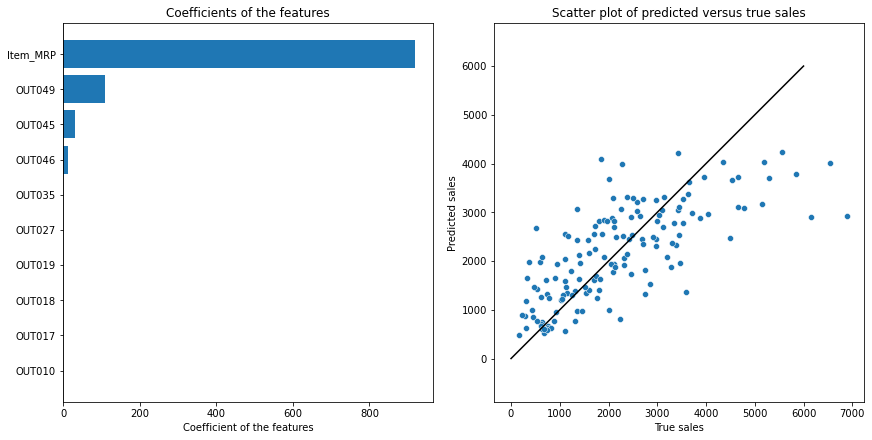

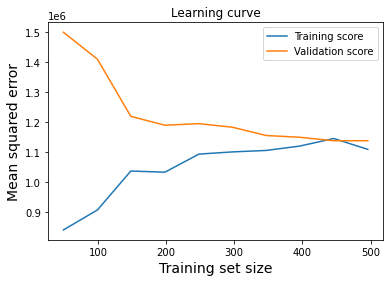

In [5]:
# Apply the Lasso regression model to a set of validation data
X_train2, X_val, y_train2, y_val = train_test_split(X_train_sc,y_train,test_size=0.2,random_state=42)
lasso_reg = Lasso(**lasso.best_params_, random_state=42)
lasso_reg.fit(X_train2,y_train2)
y_pred = lasso_reg.predict(X_val)


# Plot the coefficients of the features
fig, ax = plt.subplots(1,2,figsize=[12,6],constrained_layout = True)
sorted_idx = lasso_reg.coef_.argsort()
ax[0].barh(X_train2.columns[sorted_idx],lasso_reg.coef_[sorted_idx])
ax[0].axvline(x=0, ymin=0, ymax=1,color='k',linewidth=0.5)
ax[0].set_xlabel('Coefficient of the features')
ax[0].set_title('Coefficients of the features');


# Plot a scatter plot between the true and the predicted sales for the validation data
sns.scatterplot(x=y_val,y=y_pred,ax=ax[1])
ax[1].plot([0,6e3],[0,6e3],'k')
ax[1].axis('equal')
ax[1].set_xlabel('True sales')
ax[1].set_ylabel('Predicted sales')
ax[1].set_title('Scatter plot of predicted versus true sales');


# Learning curve
train_sizes=np.arange(0.1,1.1,0.1)
plot_learning_curve(lasso_reg,X_train_sc,y_train,train_sizes,3)

## Test data
In the last step, I evaluate the model using the test data. The resulting mean squared error (1387926) is slightly higher than the one achieved in the cross-validation (MSE = 1137844).
For comparison, the variance of the sales in the test data is 2616762.

In [6]:
# MSE of the test data
test_score = mean_squared_error(y_test,lasso_reg.predict(X_test_sc))

display('Test data: MSE =  {:.2f}'.format(test_score))

'Test data: MSE =  1387925.99'

## Summary
In this notebook, I predict the sales of the individual products in a new store. As input, I use the sales of the items in the existing stores plus the retail prices of the products. Applying a Lasso regression leads to an MSE of 1387926 and a correlation coefficient of 0.73 between the predicted and the true sales. Hence, the model performs similarly as the alternative approach, where the sales of the items in each individual store are predicted.

The retail price of the items (feature "Item_MRP") is the most important feature, the sales in the existing outlets have only a minor influence on the predictions. Therefore, the model would not greatly benefit from taking into account additional stores. Instead, additional features describing the items that are being sold should be added to the data set.

The current model is much simpler and computationally less expensive than the detailed prediction, but it achieves a similar quality in the prediction. However, there are two caveats that need to be considered when using this model. In this simple model, the individual stores are features and the items are instances. When using these data to predict the sales in another store, the model implicitly makes the assumption that the popularity of the individual items is the same in the different stores. In addition, the total sales differ between the individual stores, depending on the type of the outlet. In this example, the training data originate from outlet "OUT013", which is of the type "Supermarket Type 1". Hence, the model predicts the sales for a new store of the type "Supermarket Type 1". If the newly opened store is of a different type, e.g., a grocery store, the training data need to be adjusted accordingly.